### Show quantile estimation with SGD  "works"

1. Test datasets:
    - Mixsture of 5 Gaussians
    - Sample of 100k from no.1
    - Gausian $\mu = 2, \sigma = 18$
    - Gausian $\mu = 0, \sigma = 0.001$
    - Sample 100 from no.1
    - Sample 100 from no.3
    - Exponential $\lambda$
    - My weird distribution lol
    
4. Test times:
    - 10 $\times$ dataset generation
    - 10 $\times$ SGD ???
    - 10 $\times$ shuffle (does the order matter?)
    
2. Q value: 0.1, 0.3, 0.5, 0.9, 0.99 

3. Step size: 
    - $\alpha_k = 1$
    - $\alpha_k = \frac{2}{\sqrt{k}}$
    - $\alpha_k = \frac{0.002}{\sqrt{k}}$
    - ?
    - ?
    - Why's the Newton method helpful?
       
5. Calculate $E = |q_{batch} - q_{sgd}|$

6. What's a small value of $E$?

7. Investigate the effect of datasize N
    - Convergence rate with same $\alpha_k$?
    - Different Q values?
    - ?

In [1]:
%matplotlib inline

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx


# import import_ipynb
# from plt_quantile_comparison import plot_quantile_shuffles, plot_quantile_generations

In [539]:
distro_list = ['mix', 'gau 1', 'gau 2', 'exp']
stepsize_list = ['const', '2/sqrt_k', '0.002/sqrt_k']

tau_vals = [0.1, 0.3, 0.5, 0.9, 0.99]
N_g = 12 # N_generation
N_s = 10 # N_shuffle

N_q = len(tau_vals)

c_Norm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('cool'))

In [440]:
# all of the inputs are in the form of list
# e.g. distro = [mix_gaussian], datasize = [100, 100000], stepsize = [2]
def get_n_comp(distro, datasize, stepsize):
    print ('get_compared_setting()', distro, datasize, stepsize)
    if len(distro) > 1:
        if len(datasize)!= 1 or len(stepsize)!=1:
            raise Exception('The number of comp_setting is incorrect')
        return len(distro)
    elif len(datasize) > 1:
        if len(stepsize)!=1:
            raise Exception('The number of comp_setting is incorrect')        
        return len(datasize)
    elif len(stepsize) > 1:
        print ('step size')
        return len(stepsize)
    raise Exception('The number of comp_setting is incorrect')

def generate_setting_lst(distro, datasize, q_lst, g_test, s_test):
    setting_lst = []
    if len(distro)>1:
        for dis in distro:
            setting_lst.append([dis, datasize[0], q_lst, g_test, s_test])
    else:
        for size in datasize:
            setting_lst.append([distro[0], size, q_lst, g_test, s_test])
    print (setting_lst)
    return setting_lst

### Dataset and quantile generation

#### Helping functions for data generation

In [441]:
# distro_list = ['mix_gau', 'gau 1', 'gau 2', 'exp', 'my_distro']

def generate_single_dataset(distro, datasize):
    if distro == 'gau 1':
        return np.random.normal(2, 18, datasize)
    elif distro == 'gau 2':
        return np.random.normal(0, 0.001, datasize)
    elif distro == 'mix':
        sizes = np.array([0.3, 0.2, 0.1, 0.15, 0.25]) * datasize
        d1 = np.random.normal(2.0, 7.0, int(sizes[0]))
        d2 = np.random.normal(0, 3.7, int(sizes[1]))
        d3 = np.random.normal(-9, 7, int(sizes[2]))
        d4 = np.random.normal(5, 77, int(sizes[3]))
        d5 = np.random.normal(-7, 7, int(sizes[4]))
        mix_lst = np.append(d1, np.append(d2, np.append(d3, np.append(d4, d5))))
        np.random.shuffle(mix_lst)
        return mix_lst
    elif distro == 'exp':
        return np.random.exponential(scale=1, size=datasize)

In [442]:
def generate_dataset(distro, datasize, g_test, s_test):
#     print ('generate_dataset', distro, datasize, g_test, s_test)
#     shape of dataset: 1*Datasize,
    if not g_test and not s_test:
        return generate_single_dataset(distro, datasize)
            
    elif g_test and not s_test:
        generated_dt = np.zeros((N_g, datasize))
        for i in range(N_g):
            generated_dt[i] = generate_single_dataset(distro, datasize)
        return generated_dt
    
    elif s_test and not g_test:
        shuffled_dt = np.zeros((N_s, datasize))
        dt = generate_single_dataset(distro, datasize)
        for i in range(N_s): 
            np.random.shuffle(dt)
            shuffled_dt[i] = dt
        return shuffled_dt
        
    dataset = np.zeros((N_g, N_s, datasize))
    for gen_id in range(N_g):
        dt = generate_single_dataset(distro, datasize)
        for shu_id in range(N_s):
#             print (gen_id, shu_id)
            np.random.shuffle(dt)
            dataset[gen_id][shu_id] = dt
    return dataset

In [443]:
def test_generate_dataset():
    distro = 'mix'
    datasize = 10000

    data_shuffle = generate_dataset(distro, datasize, False, True)
    data_gen = generate_dataset(distro, datasize, True, False)

    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
    fig.set_size_inches(17, 12)
    num_bins = 100
    ax1.hist([dt for dt in data_shuffle[:3]], num_bins, alpha = 0.5, label=[str(i) for i in range(20)])
    ax1.legend()
    ax2.hist([dt for dt in data_gen[:3]], num_bins, alpha = 0.5, label=[str(i) for i in range(20)])
    ax2.legend()
    plt.show()
# test_generate_dataset()

#### Helping functions for q_batches

In [444]:
def generate_q_batches_single_dataset(dataset, q_lst):
    q_batches = np.zeros(len(q_lst))
    for i in range(len(q_lst)):
        q_batches[i] = np.percentile(dataset, q_lst[i]*100)
    return q_batches

# test
# generate_q_batches_single_dataset(dataset, [0])[0] == min(dataset) and generate_q_batches_single_dataset(dataset, [1])[0] == max(dataset)

def generate_q_batches(dataset, q_lst, g_test, s_test):
#     print ('generate_q_batches', dataset, g_test, s_test)
    if not g_test:
        if s_test:
            return generate_q_batches_single_dataset(dataset[0], q_lst)
        else: 
            return generate_q_batches_single_dataset(dataset, q_lst)
    else:
        N_g = dataset.shape[0]
        q_batches = np.zeros((N_g, len(q_lst)))
        for i in range(N_g):
            if not s_test:
                q_batches[i] = generate_q_batches_single_dataset(dataset[i], q_lst)
            else:
                q_batches[i] = generate_q_batches_single_dataset(dataset[i][0], q_lst)
        return q_batches

In [445]:
def sgd_init_changed(dataset, stepsize, tau, q_init=0):
    q_sgd_proc = np.zeros(len(dataset))
    q = 0
    
    init_k = int(1.0/(min(tau, 1-tau)))

    for k, x in enumerate(dataset):
        if k < init_k:
            q = min(q, x) if tau < 0.5 else max(q,x)
        else:
            alpha = set_stepsize(k+1, stepsize)
            if x > q:
                q += alpha*tau
            else:
                q -= alpha*(1-tau)
        q_sgd_proc[k] = q
    return q_sgd_proc

dataset = np.arange(1,101)
np.random.shuffle(dataset)
# print (dataset)
stepsize = 'const'
tau = 0.9
sgd_init_changed(dataset, stepsize, tau)

array([69. , 69. , 69. , 97. , 97. , 97. , 97. , 97. , 97. , 97. , 96.9,
       96.8, 96.7, 96.6, 96.5, 96.4, 96.3, 96.2, 96.1, 96. , 95.9, 95.8,
       95.7, 95.6, 95.5, 95.4, 95.3, 95.2, 95.1, 95. , 94.9, 94.8, 94.7,
       94.6, 94.5, 94.4, 94.3, 94.2, 94.1, 94. , 93.9, 93.8, 93.7, 94.6,
       94.5, 94.4, 94.3, 94.2, 94.1, 94. , 93.9, 93.8, 93.7, 94.6, 94.5,
       94.4, 94.3, 94.2, 94.1, 94. , 93.9, 93.8, 93.7, 93.6, 93.5, 93.4,
       93.3, 93.2, 93.1, 93. , 92.9, 92.8, 92.7, 92.6, 92.5, 92.4, 92.3,
       92.2, 92.1, 92. , 91.9, 91.8, 92.7, 92.6, 92.5, 92.4, 92.3, 92.2,
       92.1, 93. , 92.9, 92.8, 92.7, 93.6, 93.5, 93.4, 93.3, 93.2, 93.1,
       93. ])

#### Helping functions for q_sgds

In [551]:
def set_stepsize(k, stepsize):
    if stepsize=='const':
        return 1
    elif stepsize=='2/sqrt_k':
        return 2/math.sqrt(k)
    elif stepsize=='0.002/sqrt_k':
        return 0.002/math.sqrt(k)
    raise Exception('stepsize parameter is wrong')


    
def sgd(dataset, stepsize, tau):
    q_sgd_proc = np.zeros(len(dataset))
    q= 0
    for k, x in enumerate(dataset):
        alpha = set_stepsize(k+1, stepsize)
        if x > q:
            q += alpha*tau
        else:
            q -= alpha*(1-tau)
        q_sgd_proc[k] = q
    return q_sgd_proc

def generate_q_sgd_proc_single_dataset(dataset, stepsize, tau_lst, modified_sgd=False):
    q_sgd_procs = np.zeros((len(tau_lst), len(dataset)))
    for idx, tau in enumerate(tau_lst):
        if modified_sgd: 
            q_sgd_procs[idx] = sgd_init_changed(dataset, stepsize, tau)
        else:
            q_sgd_procs[idx] = sgd(dataset, stepsize, tau)
        
    return q_sgd_procs

def generate_q_sgd_proc(dataset, stepsize, tau_lst):
    N_q = len(tau_lst)
    N_dim = len(dataset.shape)
    
    q_shape = list(dataset.shape)
    q_shape.insert(-1, N_q)
    filename = 'q_sgd_procs.dat'
    q_sgd_procs = np.memmap(filename, dtype=np.float32, mode='w+', shape=tuple(q_shape))
    
    if N_dim==1:
        q_sgd_procs[:] = generate_q_sgd_proc_single_dataset(dataset, stepsize, tau_lst)
    
    elif N_dim==2:
        for idx, dt in enumerate(dataset):
            q_sgd_procs[idx] = generate_q_sgd_proc_single_dataset(dt, stepsize, tau_lst)
    
    elif N_dim==3:
        for g_idx, dt_g in enumerate(dataset):
            for s_idx, dt in enumerate(dt_g):
                q_sgd_procs[g_idx][s_idx] = generate_q_sgd_proc_single_dataset(dt, stepsize, tau_lst)
                
    else:  raise Exception('dataset of wrong type! check the dataset!')
        
    return filename, tuple(q_shape)

In [447]:
def generate_q_sgd_res(filename, shape):
    N_dim =len(shape)-1
    print (N_dim)

    q_sgd_proc = np.memmap(filename, dtype=np.float32, mode='r', shape=shape)
#     print (q_sgd_proc)
    
    if N_dim==1:
        return np.array(q_sgd_proc[:, -1])
        
    elif N_dim==2:
        return np.array(q_sgd_proc[:,:,-1])
    
    elif N_dim==3:
        return np.array(q_sgd_proc[:,:,:,-1])
    
    else: raise Execption('q_sgd_proc file got wrong')

#### Main functions for data and quantile generation

In [448]:
def generate_reusable_data(distro, datasize, q_lst, g_test, s_test):
    print ('generate_reusable_data', (distro, datasize, q_lst, g_test, s_test))
    dataset = generate_dataset(distro, datasize, g_test, s_test)
    q_batches = generate_q_batches(dataset, q_lst, g_test, s_test)
    return dataset, q_batches

def generate_q_sgds(dataset, stepsize, q_lst):
    filename, shape = generate_q_sgd_proc(dataset, stepsize, q_lst)
    # q_sgd_procs are stored by np.memmap
    q_sgd_res  = generate_q_sgd_res(filename, shape)
    return q_sgd_res, filename, shape


### Plots

#### Helping functions to charts drawing

In [449]:
# Generate data to test plots
# dataset = generate_dataset(distro=distro_list[0], datasize=1000, g_test=False, s_test=False)
dataset, q_batches = generate_reusable_data(distro=distro_list[3], datasize=1000, q_lst=tau_vals,
                                            g_test=True, s_test=True)
q_sgd_res, proc_filename, proc_shape = generate_q_sgds(dataset, stepsize_list[1], tau_vals)
# print (q_batches)
print (q_sgd_res.T.shape)

generate_reusable_data ('exp', 1000, [0.1, 0.3, 0.5, 0.9, 0.99], True, True)
3
(5, 10, 12)


In [450]:
def plt_stripe(tau_lst, ax, q_lst, pattern, name):
    hist_on = (len(q_lst.shape) > 2)
    q_lst = q_lst.T
    for idx, q in enumerate(q_lst):
        colorVal = scalarMap.to_rgba(tau_lst[idx])
        lb = str(+tau_lst[idx])+name
        if not hist_on:
            line = ax.plot([q,q], [0,1], pattern, color=colorVal)
            line[0].set_label(lb)
        else:
            bins = 30
            line = ax.hist(q.reshape(-1), bins, color=colorVal, label=lb)


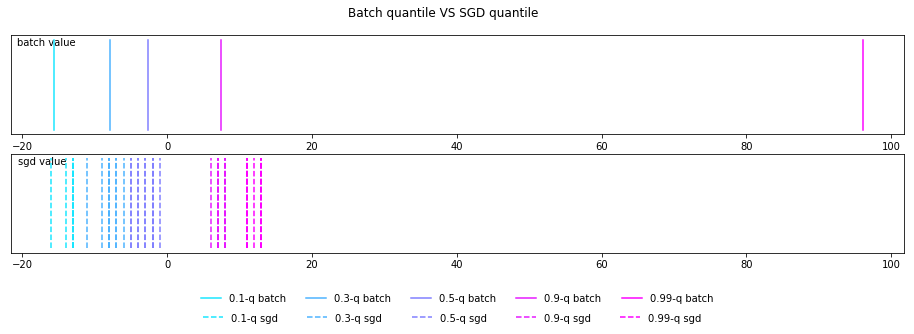

In [540]:
def plot_spectrum_stripes(q_lst, q_batches, q_sgd_res):
    c_Norm = colors.Normalize(vmin=0, vmax=1)
#     scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('cool'))
    styles = ['-', '--']
    names = ['-q batch', '-q sgd   ']
    
    fig = plt.figure(figsize=(16,4))
    ax_batch = fig.add_subplot(211)
    ax_sgd = fig.add_subplot(212, sharex = ax_batch)
    fig.suptitle('Batch quantile VS SGD quantile')
    
    plt_stripe(q_lst, ax_batch, q_batches, styles[0], names[0])
    plt_stripe(q_lst, ax_sgd, q_sgd_res, styles[1], names[1])

    #set 
    ax_batch.set_xlabel('batch value')
    ax_batch.xaxis.set_label_coords(0.04, 0.98)
    ax_batch.set_yticks([])

    plt.locator_params(axis='x', nbins=10)

    ax_sgd.set_xlabel('sgd value')
    ax_sgd.xaxis.set_label_coords(0.035, 0.98)
    ax_sgd.set_yticks([])


    # set position of legend
    ax_batch.legend(loc='lower center', bbox_to_anchor=(0.5, -1.8),
            frameon=False, ncol=len(q_lst))
    ax_sgd.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8),
        frameon=False, ncol=len(q_lst))
        
#     return fig

plot_spectrum_stripes(tau_vals, q_batches, q_sgd_res)

In [554]:
q_lst = [0.01, 0.5,0.99]
dataset, q_batches = generate_reusable_data(distro=distro_list[0], datasize=1000, q_lst=q_lst,
                                            g_test=True, s_test=False)
q_sgd_res, proc_filename, proc_shape = generate_q_sgds(dataset, stepsize_list[0], q_lst)
# print (q_batches)
# print (q_sgd_res.T.shape)
q_procs = np.memmap(proc_filename, np.float32, 'r+', shape=proc_shape)
q_procs.shape
# q_batches.mean(axis=0)

generate_reusable_data ('mix', 1000, [0.01, 0.5, 0.99], True, False)
2


(12, 3, 1000)

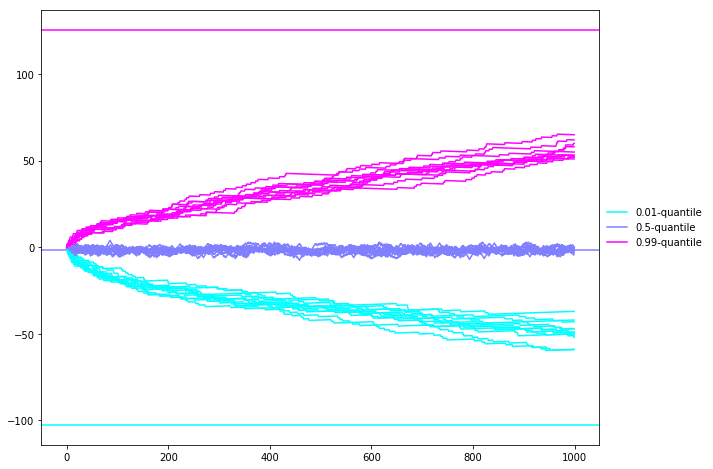

In [555]:
def plot_one_proc(tau_lst, q_proc, ax, label_on):
    for idx, q in enumerate(q_proc):
        colorVal = scalarMap.to_rgba(tau_lst[idx])
        lb = str(+tau_lst[idx])+'-quantile' if label_on else ''
        ax.plot(q, color=colorVal, label=lb)

def plot_procs(tau_lst, q_batches, proc_name, proc_shape):
    q_procs = np.memmap(proc_name, np.float32, 'r+', shape=proc_shape)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    N_dim = len(q_procs.shape)

    if len(q_batches.shape)==2: q_batches = q_batches.mean(axis=0)
    for idx, q in enumerate(q_batches):
        colorVal = scalarMap.to_rgba(tau_lst[idx])                
        ax.axhline(q, color=colorVal)
            
    if N_dim == 2:
        plot_one_proc(tau_lst, q_procs, ax, True)
            
    elif N_dim == 3: 
        for i, q_dt in enumerate(q_procs):
            label_on = True if i == 0 else False
            plot_one_proc(tau_lst, q_dt, ax, label_on)

    elif N_dim > 3:
        raise  Exception ("q_sgd_proc too much to be printed")

    ax.legend(loc='right', bbox_to_anchor=(1.2, 0.5),
        frameon=False, ncol=1)
    
#     return fig

plot_procs(q_lst, q_batches, proc_filename, proc_shape)

In [534]:
# q_lst = [0.9,0.99]
q_lst=tau_vals
dataset, q_batches = generate_reusable_data(distro=distro_list[0], datasize=100, q_lst=q_lst,
                                            g_test=False, s_test=True)
q_sgd_res, proc_filename, proc_shape = generate_q_sgds(dataset, stepsize_list[0], q_lst)
# print (q_batches)
# print (q_sgd_res.T.shape)
q_procs = np.memmap(proc_filename, np.float32, 'r+', shape=proc_shape)
# (q_sgd_res - q_batches).T
# q_batches.mean(axis=0)

generate_reusable_data ('mix', 100, [0.1, 0.3, 0.5, 0.9, 0.99], False, True)
2


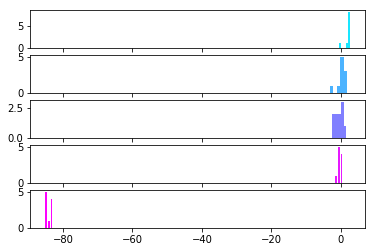

In [541]:
def compute_E_res(tau_lst, q_batches, q_sgd_res):
#     if len(q_batches.shape)==len(q_sgd_res.shape):
    if len(q_sgd_res.shape) < 3:    
        e = q_sgd_res - q_batches
    else:
        e = np.zeros(q_sgd_res.shape)
        for i, q_res_g in enumerate(q_sgd_res):
            e[i] = q_res_g - q_batches[i]
    return e
    
e = compute_E_res(tau_vals, q_batches, q_sgd_res)

def plot_E_res(tau_lst, e):
    e = e.T
    if len(e.shape)>2: raise Exception('E shape is too high!')
    fig, axes = plt.subplots(nrows=len(tau_lst), sharex=True)
    for i, ax in enumerate(axes):
        colorVal = scalarMap.to_rgba(tau_lst[i])
        ax.hist(e[i], bins=5, color=colorVal)
#     return fig

plot_E_res(tau_vals, e)

In [ ]:
def compute_E_proc():
    return
    

In [ ]:
def plot_charts(q_lst, q_batches, q_sgd_res, proc_filename, proc_shape, g_test, s_test, charts):
#     return plts
    return 4

def plot_tables(q_lst, q_batches, q_sgd_res, proc_filename, proc_shape, g_test, s_test, charts):
#     return tbls
    return 5

In [ ]:
# Conduct experiments on quantile estimation with SGD with regards to different aspects
# Experiment results are shown in charts and tables
# 
# Return: None? or charts and figures
#
# Inputs: 
#     1. Parameters for the experiments
#         - Settings to change: one of {distro, datasize, stepsize} (all elements are lists/dict)
#         - Settings to control: the left two of {distro, datasize, stepsize}
#                                g_test, s_test
#     2. Values to show in the results
#         - q_values to be compared
#         - charts to be showen in {plt_res, plt_proc, plt_e}
#         - tables to be shown in {tbl_res, tbl_proc}

def quantile_sgd_compare(distro, datasize, stepsize, 
                            g_test=False, s_test=False, q_lst=tau_vals, 
                           charts={'plt_res', 'plt_proc', 'plt_e'}, tables={'tbl_res, tbl_proc'}):
    dataset, q_batches = 0, 0
    N_comp = get_n_comp(distro, datasize, stepsize)
    
    print (N_comp)
    
    if len(stepsize)==1:
        setting_lst = generate_setting_lst(distro, datasize, q_lst, g_test, s_test)
    else:
        dataset, q_batches = generate_reusable_data(distro[0], datasize[0], q_lst, g_test, s_test)
        print (dataset.shape, q_batches)

    # for each round, generate all data and comparison results
    for i in range(N_comp):
        if len(stepsize)==1:
            print ("generate the {}th dataset and q_batches".format(i))
            lst = setting_lst[i]
            distro, datasize, q_lst, g_test, s_test = lst[0], lst[1], lst[2], lst[3], lst[4]
            dataset, q_batches = generate_reusable_data(distro, datasize, q_lst, g_test, s_test)
            print (dataset.shape, q_batches)
            q_sgd_res, proc_filename, proc_shape = generate_q_sgds(dataset, stepsize[0], q_lst)
        else:
            print ('different q_sgd', i , 'for same dataset and q_batches')
            q_sgd_res, proc_filename, proc_shape = generate_q_sgds(dataset, stepsize[i], q_lst, g_test, s_test)
        plts = plot_charts(q_lst, q_batches, q_sgd_res, proc_filename, proc_shape, g_test, s_test, charts)
        tbls = plot_tables(q_lst, q_batches, q_sgd_res, proc_filename, proc_shape, g_test, s_test, tables)
    # have them together?
    
    return
    

In [ ]:
# distro_list = ['mix_gau', 'gau 1', 'gau 2', 'exp', 'my_distro']
# stepsize_list = ['const', '2/sqrt_k', '0.002/sqrt_k']

quantile_sgd_compare(['gau 1', 'gau 2'], [100], ['const'], True)

In [ ]:
# plt: errorbar
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/errorbar_subsample.html#sphx-glr-gallery-lines-bars-and-markers-errorbar-subsample-py